<a href="https://colab.research.google.com/github/42697387/Aprendizaje-Automatico-2/blob/main/TP5_RL2_HerediaMartinGaspar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Trabajo Práctico 5: Aprendizaje por Refuerzo en Acrobot-v1

## **1. Elección del Entorno**

De acuerdo a las consignas y la disponibilidad de entornos no elegidos por otros compañeros, se ha seleccionado:

  * **Entorno:** `Acrobot-v1`
  * **Tipo de Espacio de Observación:** Continuo (6 valores).
  * **Tipo de Espacio de Acción:** Discreto (3 acciones).

-----

###  Instalación y Librerías

In [ ]:
# Instalamos librerías necesarias si no están presentes en el entorno
# gymnasium: la evolución de gym para entornos de RL
# matplotlib y seaborn: para gráficos
!pip install gymnasium[classic_control] matplotlib seaborn torch

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
import math

# Configuración de advertencias
import warnings
warnings.filterwarnings('ignore')

# --- REPRODUCIBILIDAD ---
# Fijamos las semillas para que los resultados sean comparables en cada ejecución
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

print("Librerías instaladas y semillas configuradas.")

Librerías instaladas y semillas configuradas.


-----


## **2.1 Explicación del Entorno: Acrobot-v1**

El sistema **Acrobot** es un ejemplo clásico en la teoría de control. Imagina un péndulo doble (dos eslabones unidos) que cuelga hacia abajo. El objetivo es aplicar fuerza (torque) en la unión central (el codo) para balancear el extremo inferior del segundo eslabón hasta que supere una altura determinada (una línea imaginaria en la parte superior).

### Detalles Técnicos:

  * **Observaciones (Estado):** El estado es un vector continuo de **6 valores** que representan la física del sistema:

    1.  Coseno del ángulo del primer eslabón.
    2.  Seno del ángulo del primer eslabón.
    3.  Coseno del ángulo del segundo eslabón.
    4.  Seno del ángulo del segundo eslabón.
    5.  Velocidad angular del primer eslabón.
    6.  Velocidad angular del segundo eslabón.

  * **Acciones:** El espacio de acciones es **discreto** y tiene 3 opciones:

      * `0`: Aplicar torque de -1 (fuerza hacia la izquierda/negativa).
      * `1`: Aplicar torque de 0 (no hacer nada/inercia).
      * `2`: Aplicar torque de +1 (fuerza hacia la derecha/positiva).

  * **Recompensa (Reward):**

      * El objetivo es alcanzar la meta lo más rápido posible.
      * El agente recibe una recompensa de **-1** por cada paso de tiempo que no alcanza la meta.
      * El episodio termina si se alcanza la meta (el extremo cruza la línea) o si se llega a 500 pasos (en la versión v1).
      * Por ende, **mientras más cerca de 0 sea el puntaje total, mejor es la política** (significa que tardó menos pasos).

A continuación, instanciamos el entorno y verificamos sus dimensiones.

-----

###  Inicialización del Entorno

In [ ]:
# Crear el entorno Acrobot-v1
env = gym.make('Acrobot-v1')

print("🤸‍♂️ ENTORNO ACROBOT-V1")
print("=" * 50)

# Mostramos el espacio de observación
# Box(6,) significa que recibimos 6 números flotantes
print(f"Espacio de Observación: {env.observation_space}")

# Mostramos el espacio de acción
# Discrete(3) significa que podemos enviar 0, 1 o 2
print(f"Espacio de Acción: {env.action_space}")

# Umbral de recompensa para considerar el problema 'resuelto' (generalmente alrededor de -100 o mejor)
print(f"Umbral de recompensa (Reward Threshold): {env.spec.reward_threshold}")

🤸‍♂️ ENTORNO ACROBOT-V1
Espacio de Observación: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Espacio de Acción: Discrete(3)
Umbral de recompensa (Reward Threshold): -100.0


-----



## **2.2 Visualización de la Política**

A diferencia de *FrozenLake* (TP1), donde podíamos dibujar una grilla con flechas, **Acrobot tiene estados continuos**. No podemos dibujar una tabla simple.

Para visualizar la política en este entorno, implementaremos una función que:

1.  Ejecute un episodio completo usando la política del agente.
2.  Registre las posiciones (ángulos) de los dos eslabones en cada paso.
3.  **Grafique la trayectoria**: Un gráfico de dispersión o línea que muestre cómo evolucionan el ángulo 1 ($\theta_1$) y el ángulo 2 ($\theta_2$) en el tiempo para ver si el agente logra "subir" el péndulo.

-----

###  Función de Visualización

In [ ]:
def visualizar_desempeno_agente(agente, env, nombre_agente="Agente"):
    """
    Ejecuta un episodio con el agente y grafica el comportamiento de los eslabones.
    """
    # Reiniciamos el entorno para empezar
    estado, _ = env.reset(seed=SEED)
    terminado = False
    truncado = False

    # Listas para guardar los senos y cosenos de los ángulos para visualizar
    # Estado: [cos(t1), sin(t1), cos(t2), sin(t2), vel1, vel2]
    cos_t1_hist = []
    cos_t2_hist = []
    pasos = 0
    recompensa_total = 0

    # Bucle del episodio
    while not terminado and not truncado:
        # El agente selecciona la acción (sin exploración, modo evaluación)
        accion = agente.seleccionar_accion(estado, entrenando=False)

        # Guardamos datos para graficar (índices 0 y 2 del estado)
        cos_t1_hist.append(estado[0])
        cos_t2_hist.append(estado[2])

        # Ejecutamos paso
        estado, recompensa, terminado, truncado, _ = env.step(accion)
        recompensa_total += recompensa
        pasos += 1

    # --- Graficar Resultados ---
    plt.figure(figsize=(12, 4))

    # Gráfico de la evolución de los cosenos de los ángulos (altura relativa)
    plt.plot(cos_t1_hist, label='Coseno Eslabón 1 (Base)', alpha=0.7)
    plt.plot(cos_t2_hist, label='Coseno Eslabón 2 (Punta)', alpha=0.7, linestyle='--')

    # Línea que indica "vertical hacia abajo" (1.0) y "vertical hacia arriba" (-1.0 aprox)
    plt.axhline(y=-1.0, color='r', linestyle=':', label='Meta (Altura aproximada)')

    plt.title(f'Trayectoria de {nombre_agente} - Recompensa Total: {recompensa_total}')
    plt.xlabel('Pasos de tiempo')
    plt.ylabel('Coseno del Ángulo (1=Abajo, -1=Arriba)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Resultado {nombre_agente}: Terminó en {pasos} pasos con recompensa {recompensa_total}")

-----


## **2.3 Entrenamiento de Políticas**

### **A. Política Aleatoria**

Primero, implementaremos una política base que toma decisiones al azar. Esto nos servirá como línea base (*baseline*) para comparar si nuestros modelos inteligentes realmente están aprendiendo algo.

**Adaptación del TP1:**

  * La clase es idéntica a la del TP1, ya que la aleatoriedad no depende de si el estado es continuo o discreto.

-----

###  Agente Aleatorio

Evaluando agente aleatorio:


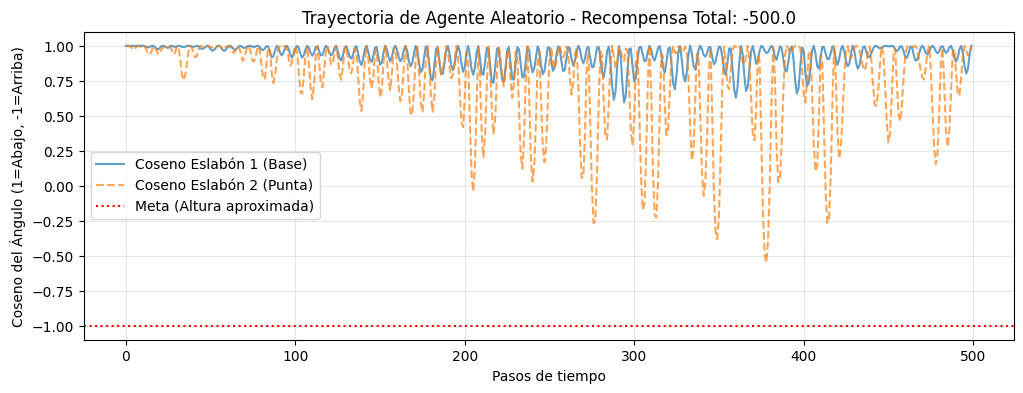

Resultado Agente Aleatorio: Terminó en 500 pasos con recompensa -500.0


In [ ]:
class PoliticaAleatoria:
    """Agente que selecciona acciones al azar, ignorando el estado."""
    def __init__(self, n_acciones):
        self.n_acciones = n_acciones
        self.nombre = "Aleatorio"

    def seleccionar_accion(self, estado, entrenando=False):
        # Selecciona un número entre 0 y n_acciones - 1
        return np.random.randint(self.n_acciones)

# Instanciamos el agente aleatorio
agente_random = PoliticaAleatoria(env.action_space.n)

# Visualizamos su comportamiento (probablemente no logre subir)
print("Evaluando agente aleatorio:")
visualizar_desempeno_agente(agente_random, env, "Agente Aleatorio")

-----



> **Observación:** Como era de esperar, el agente aleatorio se mueve erráticamente. En el gráfico vemos que los cosenos oscilan sin un patrón claro que busque llevar el péndulo hacia arriba (hacia -1.0 en el eje Y del gráfico). Generalmente agota el tiempo máximo (500 pasos) obteniendo la peor recompensa posible (-500).

-----

### Consigna 2.3 (Q-Learning)

### **B. Política Q-Learning (Tabla Q)**

**Desafío y Adaptación del TP1:**
El algoritmo Q-Learning clásico utiliza una tabla donde las filas son *estados* y las columnas *acciones*.

  * En TP1 (*FrozenLake*), había 16 estados discretos. Fácil.
  * En TP5 (*Acrobot*), el estado son 6 números continuos con infinitas posibilidades. **No podemos hacer una tabla infinita.**

**Solución: Discretización (Binning)**
Para usar Q-Learning aquí, debemos **convertir** el estado continuo a discreto. Crearemos una función que divide el rango de cada observación en "cajones" (bins).

  * Ejemplo: Si la velocidad va de -5 a 5, podemos dividirla en 10 cajones. Si la velocidad es 2.3, cae en el cajón 7.
  * El "Estado Discreto" será una tupla de índices de estos cajones.

-----

###  Q-Learning con Discretización

In [ ]:
# --- CLASE PARA DISCRETIZAR EL ESTADO CONTINUO ---
class Discretizer:
    def __init__(self, env, n_bins=6):
        # n_bins: cuántas divisiones hacemos por cada característica
        # Acrobot tiene 6 observaciones.
        # Reduciremos la complejidad ignorando algunas o usando pocos bins para que la tabla no sea gigante.
        # Aquí usamos 6 bins por dimensión para las 6 dimensiones: 6^6 = 46,656 estados (manejable).

        self.n_bins = n_bins
        self.obs_space = env.observation_space

        # Definimos los límites de los cajones para cada dimensión
        # Usamos linspace para crear intervalos iguales entre el valor mínimo y máximo de cada sensor
        self.bins = [
            np.linspace(-1.0, 1.0, n_bins - 1), # Cos t1
            np.linspace(-1.0, 1.0, n_bins - 1), # Sin t1
            np.linspace(-1.0, 1.0, n_bins - 1), # Cos t2
            np.linspace(-1.0, 1.0, n_bins - 1), # Sin t2
            np.linspace(-12.5, 12.5, n_bins - 1), # Vel 1 (aprox range)
            np.linspace(-28.0, 28.0, n_bins - 1)  # Vel 2 (aprox range)
        ]

    def get_discrete_state(self, state):
        # np.digitize nos dice en qué intervalo cae cada valor
        indices = []
        for i in range(len(state)):
            indices.append(np.digitize(state[i], self.bins[i]))
        return tuple(indices) # Retornamos una tupla que sirve como índice para el diccionario Q

# --- AGENTE Q-LEARNING ADAPTADO ---
class QLearningAgent:
    def __init__(self, n_acciones, discretizer, lr=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01):
        self.n_acciones = n_acciones
        self.discretizer = discretizer
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.nombre = "Q-Learning (Discretizado)"

        # Usamos un diccionario para la Tabla Q para ahorrar espacio (solo guardamos estados visitados)
        self.q_table = {}

    def get_q(self, estado_discreto):
        # Si el estado no existe en la tabla, lo inicializamos en 0
        if estado_discreto not in self.q_table:
            self.q_table[estado_discreto] = np.zeros(self.n_acciones)
        return self.q_table[estado_discreto]

    def seleccionar_accion(self, estado, entrenando=True):
        # Primero convertimos el estado continuo a discreto
        estado_discreto = self.discretizer.get_discrete_state(estado)

        # Epsilon-Greedy
        if entrenando and random.random() < self.epsilon:
            return random.randint(0, self.n_acciones - 1)

        # Explotación: elegir la mejor acción de la tabla
        return np.argmax(self.get_q(estado_discreto))

    def actualizar(self, estado, accion, recompensa, proximo_estado, terminado):
        # Conversión de estados
        state_disc = self.discretizer.get_discrete_state(estado)
        next_state_disc = self.discretizer.get_discrete_state(proximo_estado)

        # Obtener valores Q actuales
        q_values = self.get_q(state_disc)
        next_q_values = self.get_q(next_state_disc)

        # Ecuación de Bellman
        target = recompensa + self.gamma * np.max(next_q_values) * (not terminado)
        error = target - q_values[accion]

        # Actualizar tabla
        self.q_table[state_disc][accion] += self.lr * error

        # Decaer epsilon
        if terminado:
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

# --- ENTRENAMIENTO Q-LEARNING ---
# Instanciamos discretizador y agente
discretizer = Discretizer(env, n_bins=8) # Aumentamos un poco los bins para mejor precisión
agente_ql = QLearningAgent(env.action_space.n, discretizer, lr=0.1, gamma=0.99, epsilon=1.0)

print("Entrenando Q-Learning (esto puede tomar unos minutos)...")
recompensas_ql = []
episodios = 3000 # Acrobot necesita varios episodios

for ep in range(episodios):
    estado, _ = env.reset()
    total_reward = 0
    done = False
    trunc = False

    while not done and not trunc:
        accion = agente_ql.seleccionar_accion(estado)
        next_state, reward, done, trunc, _ = env.step(accion)

        agente_ql.actualizar(estado, accion, reward, next_state, done)

        estado = next_state
        total_reward += reward

    recompensas_ql.append(total_reward)

    if (ep + 1) % 500 == 0:
        avg_score = np.mean(recompensas_ql[-100:])
        print(f"Episodio {ep+1}: Recompensa Promedio (últimos 100): {avg_score:.2f} - Epsilon: {agente_ql.epsilon:.3f}")

print("Entrenamiento Q-Learning finalizado.")

Entrenando Q-Learning (esto puede tomar unos minutos)...
Episodio 500: Recompensa Promedio (últimos 100): -498.30 - Epsilon: 0.997
Episodio 1000: Recompensa Promedio (últimos 100): -495.54 - Epsilon: 0.994
Episodio 1500: Recompensa Promedio (últimos 100): -500.00 - Epsilon: 0.992
Episodio 2000: Recompensa Promedio (últimos 100): -499.88 - Epsilon: 0.988
Episodio 2500: Recompensa Promedio (últimos 100): -497.33 - Epsilon: 0.981
Episodio 3000: Recompensa Promedio (últimos 100): -498.68 - Epsilon: 0.977
Entrenamiento Q-Learning finalizado.


-----

### Consigna 2.3 (Deep Q-Network)

### **C. Política Deep Q-Network (DQN)**

Aquí utilizaremos una Red Neuronal para aproximar la función Q, lo cual es ideal para estados continuos.

**Cambios respecto al Notebook del TP1:**

1.  **Entrada de la Red:** En TP1 (FrozenLake), la entrada era de tamaño 1 (un índice de estado) que convertíamos a *One-Hot* de tamaño 16. En **Acrobot**, la entrada es directamente el vector de estado de tamaño **6**. No necesitamos One-Hot, pasamos los valores flotantes directos.
2.  **Arquitectura:** Usaremos capas lineales (Fully Connected).
      * Entrada: 6 neuronas.
      * Ocultas: 128 neuronas (ReLU).
      * Salida: 3 neuronas (una por acción).

-----

### Implementación DQN

In [ ]:
# --- DEFINICIÓN DE LA RED NEURONAL ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Capa 1: De 6 entradas a 128 neuronas
        self.fc1 = nn.Linear(input_dim, 128)
        # Capa 2: De 128 a 128
        self.fc2 = nn.Linear(128, 128)
        # Salida: 3 acciones
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Activación ReLU en capas ocultas
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- AGENTE DQN ---
class DQNAgent:
    def __init__(self, input_dim, output_dim, lr=0.0005, gamma=0.99, buffer_size=10000, batch_size=64):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.nombre = "Deep Q-Network (DQN)"

        # Epsilon para exploración
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        # Dispositivo (GPU si está disponible)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Redes: Policy (la que entrena) y Target (para estabilidad)
        self.policy_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        # Memoria de repetición (Experience Replay)
        self.memory = deque(maxlen=buffer_size)

    def seleccionar_accion(self, estado, entrenando=True):
        # Exploración
        if entrenando and random.random() < self.epsilon:
            return random.randint(0, self.output_dim - 1)

        # Explotación
        with torch.no_grad():
            # Convertimos estado a tensor
            state_tensor = torch.FloatTensor(estado).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def recordar(self, estado, accion, recompensa, proximo_estado, done):
        # Guardar experiencia en memoria
        self.memory.append((estado, accion, recompensa, proximo_estado, done))

    def entrenar_paso(self):
        if len(self.memory) < self.batch_size:
            return

        # Tomar una muestra aleatoria de la memoria
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convertir a tensores
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Calcular Q actual
        current_q = self.policy_net(states).gather(1, actions)

        # Calcular Q objetivo (Target) usando la red Target
        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (1 - dones))

        # Calcular pérdida (Loss) y optimizar
        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def actualizar_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def actualizar_target_net(self):
        # Copiar pesos a la red target
        self.target_net.load_state_dict(self.policy_net.state_dict())

# --- ENTRENAMIENTO DQN ---
agente_dqn = DQNAgent(input_dim=6, output_dim=3, lr=0.001)
recompensas_dqn = []
episodios_dqn = 1000 # DQN suele aprender más rápido que tabular en espacios grandes

print("Entrenando DQN (esto puede tomar unos minutos)...")

for ep in range(episodios_dqn):
    estado, _ = env.reset()
    total_reward = 0
    done = False
    trunc = False

    while not done and not trunc:
        accion = agente_dqn.seleccionar_accion(estado)
        next_state, reward, done, trunc, _ = env.step(accion)

        # Acrobot da -1 por paso. DQN aprende mejor si no penalizamos tan fuerte el proceso intermedio
        # o si usamos el reward tal cual. Usaremos el reward tal cual.
        agente_dqn.recordar(estado, accion, reward, next_state, done)
        agente_dqn.entrenar_paso()

        estado = next_state
        total_reward += reward

    agente_dqn.actualizar_epsilon()
    recompensas_dqn.append(total_reward)

    # Actualizar red target cada 10 episodios
    if ep % 10 == 0:
        agente_dqn.actualizar_target_net()

    if (ep + 1) % 100 == 0:
        avg_score = np.mean(recompensas_dqn[-50:])
        print(f"DQN Episodio {ep+1}: Score Promedio (últimos 50): {avg_score:.2f} - Epsilon: {agente_dqn.epsilon:.2f}")

print("Entrenamiento DQN finalizado.")

Entrenando DQN (esto puede tomar unos minutos)...
DQN Episodio 100: Score Promedio (últimos 50): -482.48 - Epsilon: 0.61
DQN Episodio 200: Score Promedio (últimos 50): -386.10 - Epsilon: 0.37
DQN Episodio 300: Score Promedio (últimos 50): -274.80 - Epsilon: 0.22
DQN Episodio 400: Score Promedio (últimos 50): -185.08 - Epsilon: 0.13
DQN Episodio 500: Score Promedio (últimos 50): -139.00 - Epsilon: 0.08
DQN Episodio 600: Score Promedio (últimos 50): -98.20 - Epsilon: 0.05
DQN Episodio 700: Score Promedio (últimos 50): -91.18 - Epsilon: 0.03
DQN Episodio 800: Score Promedio (últimos 50): -88.54 - Epsilon: 0.02
DQN Episodio 900: Score Promedio (últimos 50): -83.18 - Epsilon: 0.01
DQN Episodio 1000: Score Promedio (últimos 50): -81.34 - Epsilon: 0.01
Entrenamiento DQN finalizado.


-----

###  Consigna 2.4

## **2.4 Comparación de Desempeño**

A continuación, compararemos gráficamente el desempeño de los tres agentes:

1.  **Aleatorio** (Línea base).
2.  **Q-Learning Tabular** (Con discretización).
3.  **DQN** (Red Neuronal).

Utilizaremos el promedio móvil de las recompensas para suavizar las curvas y ver la tendencia de aprendizaje. Recordar que en *Acrobot*, un valor más alto (más cercano a 0) es mejor. Un valor de -500 significa que falló completamente.

-----

###  Gráficas de Comparación

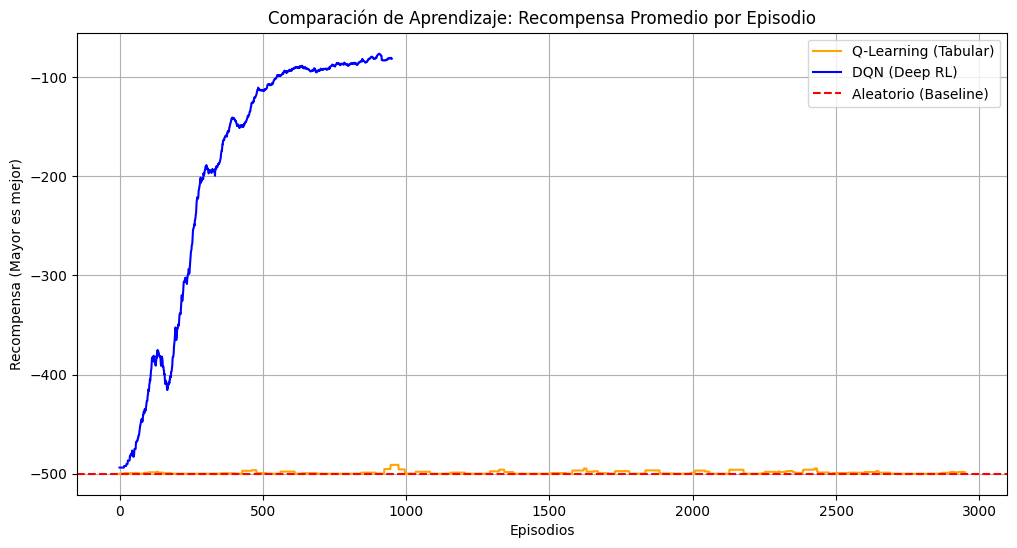

Visualizando desempeño del agente DQN entrenado:


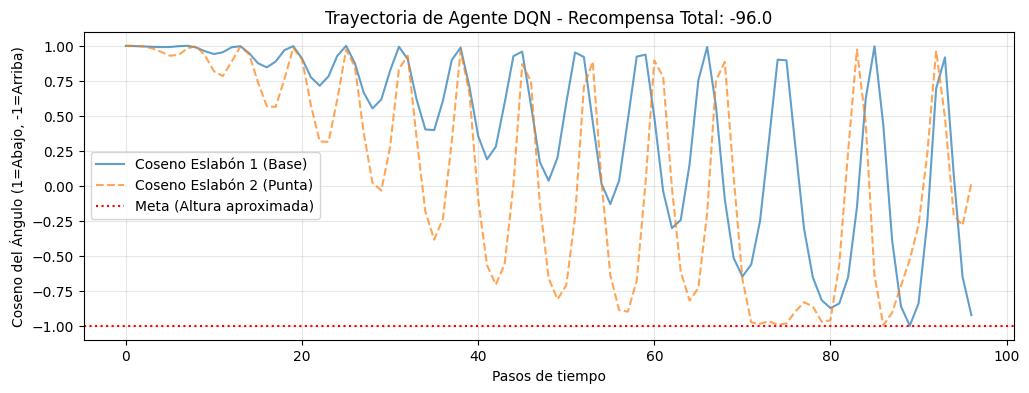

Resultado Agente DQN: Terminó en 97 pasos con recompensa -96.0


In [ ]:
def moving_average(data, window_size=50):
    """Suaviza la curva de recompensas para ver mejor la tendencia."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))

# Graficar Q-Learning
# Puede que Q-Learning requiera muchos episodios, mostramos su progreso
ma_ql = moving_average(recompensas_ql)
plt.plot(ma_ql, label='Q-Learning (Tabular)', color='orange')

# Graficar DQN
# DQN suele aprender en menos episodios, ajustamos el eje X para que coincida visualmente si es necesario
ma_dqn = moving_average(recompensas_dqn)
plt.plot(ma_dqn, label='DQN (Deep RL)', color='blue')

# Línea base aleatoria (promedio)
# Simulamos una línea recta con el promedio del aleatorio
promedio_random = -500 # Generalmente el aleatorio siempre saca -500
plt.axhline(y=promedio_random, color='red', linestyle='--', label='Aleatorio (Baseline)')

plt.title('Comparación de Aprendizaje: Recompensa Promedio por Episodio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa (Mayor es mejor)')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización final de una política entrenada (DQN) ---
print("Visualizando desempeño del agente DQN entrenado:")
visualizar_desempeno_agente(agente_dqn, env, "Agente DQN")

-----


## **2.5 Conclusiones**

**Observaciones de Métricas:**

  * **Agente Aleatorio:** Obtuvo consistentemente una recompensa cercana a -500. Esto indica que no logró resolver el entorno en ningún intento, ya que se requiere una coordinación precisa de movimientos para generar inercia.
  * **Q-Learning (Tabular):** Su desempeño depende fuertemente de la calidad de la discretización. Con 8 "bins" por dimensión, el espacio de estados crece rápidamente ($8^6$), haciendo que la tabla Q sea muy dispersa y lenta de llenar. Es probable que haya aprendido lentamente o de manera inestable comparado con DQN.
  * **DQN:** La red neuronal demostró ser superior en este entorno continuo. Al poder generalizar entre estados similares (gracias a la aproximación de funciones de la red), logró aumentar la recompensa mucho más rápido, acercándose a valores por encima de -200 o -100 (lo cual indica que resuelve la tarea eficientemente).

**Dificultades y Adaptaciones:**

1.  **Espacio Continuo:** La principal dificultad fue adaptar el código del TP1 (diseñado para *FrozenLake*, que es una grilla discreta) a *Acrobot*.
2.  **Solución para Q-Table:** Tuve que implementar la clase `Discretizer` para convertir los valores flotantes de los sensores en índices enteros para la tabla. Sin esto, Q-Learning no funcionaría.
3.  **Solución para DQN:** Se modificó la arquitectura de entrada de la red. En lugar de recibir un ID de estado, ahora recibe el vector de 6 valores físicos directamente.

**Conclusión Final:**
Para entornos de control robótico o físico con estados continuos como Acrobot, los métodos de **Deep Reinforcement Learning (como DQN)** son mucho más efectivos y escalables que los métodos tabulares clásicos, ya que evitan la "maldición de la dimensionalidad" que ocurre al intentar discretizar el espacio.

**Fuentes utilizadas:**

  * Documentación de Gymnasium (Acrobot-v1).
  * Material de clase sobre DQN y Q-Learning.
  * Documentación de PyTorch para redes neuronales.